In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import re
from collections import Counter

from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,MeanShift,AgglomerativeClustering
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
%matplotlib inline

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage

from mpl_toolkits.mplot3d import Axes3D


In [2]:
#Read files
item=pd.read_csv('data/item_to_id.csv',index_col='Item_id')
purchase_original=pd.read_csv('data/purchase_history.csv')
item.replace(u'\xa0',u'', regex=True, inplace=True)

#purchase.head()
#purchase.user_id.value_counts()






In [3]:
#For each user, get item id and count
def item_counts(same_user_df):
    all_item = same_user_df['id'].str.split(',').sum()
    return pd.Series(Counter(int(id) 
    for id in all_item))

def find_user_item_counts(purchase_original):
    purchase=purchase_original
    user_item_counts = purchase.groupby("user_id").apply(item_counts).unstack(fill_value=0)
    #user_item_counts.head()
    return user_item_counts

def normalize_user_item_count(user_item_counts):
    #Normalize user_item_counts 
    item_norm = normalize(user_item_counts.values, axis=0)
    item_item_similarity = item_norm.T.dot(item_norm)
    item_item_similarity = pd.DataFrame(item_item_similarity,index=user_item_counts.columns,columns=user_item_counts.columns)
    return item_item_similarity

def dimensionality_reduction_pca(user_item_counts,item_item_similarity,dimensions_in):
    #dimension reduction
    dimensions=dimensions_in
    pca = PCA(n_components=dimensions)
    items_pca = pca.fit_transform(item_item_similarity)
    items_pca = pd.DataFrame(items_pca,index=user_item_counts.columns,columns=["pca{}".format(index) for index in range(dimensions)])
    return pca,items_pca

In [4]:
def kmeans_cluster(pca,items_pca,n_clusters,n_components=4):
    kmeans = KMeans(init='k-means++',n_clusters=n_clusters)
    kmeans.fit(items_pca.values[:, :n_components])
    return kmeans.inertia_

def kmeans_clustering_algo(purchase_original,dimensions_list,min_k,max_k):
    for i in range(len(dimensions_list)):
        dimensions=dimensions_list[i]
        inertia=list()
        print('*************************************************************************')
        print('*********************** PCA components = ',dimensions,'*****************************')
        for k in range (min_k, max_k):
            user_item_counts=find_user_item_counts(purchase_original)
            item_item_similarity=normalize_user_item_count(user_item_counts)
            #print('item_item_similarity = ',pd.DataFrame(item_item_similarity).shape)
            pca,items_pca=dimensionality_reduction_pca(user_item_counts,item_item_similarity,dimensions)
            explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
            inertia.append(kmeans_cluster(pca,items_pca,n_clusters=k,n_components=dimensions))
            ks=range(1,k+1)
        print('Variance explained = {:.2f}%'.format(100 * sum(pca.explained_variance_ratio_[:dimensions])))

        print('Inertia = ',inertia)
        fig = plt.figure(figsize=(10,4))

        plt.plot(ks, inertia,marker='o')
        plt.show()
        print('\n\n\n\n')

In [5]:
def show_clusters(items_pca,labels):

    fig = plt.figure(figsize=(15, 15))

    colors =  itertools.cycle (["b","g","r","c","m","y","k"])
    color_names = ['blue','green','red','cyan','magenta','yellow','black']
    grps = items_pca.groupby(labels)
    print('\n')

    for label,grp in grps:
        
        print("*************** Cluster_no = ",label+1,' ******* color = ',color_names[label],'   *****************')
        plt.scatter(grp.pca1,grp.pca2,c=next(colors),label = label)

        names = item.loc[ grp.index,"Item_name"]
        cluster_groups=[]
        for index, name in enumerate(names):
            name_count=index+1
            cluster_groups.append(str(name_count)+'. '+name)
        print(cluster_groups)
        print('\n')
    for itemid in items_pca.index:
        x = items_pca.loc[itemid,"pca1"]
        y = items_pca.loc[itemid,"pca2"]
        name = item.loc[itemid,"Item_name"]
        name = re.sub('\W', ' ', name)

        plt.text(x,y,name)

In [6]:
# Clustering
def cluster(purchase_original,k,dimensions=10):

    n_components=dimensions
    inertia=list()

    user_item_counts=find_user_item_counts(purchase_original)
    item_item_similarity=normalize_user_item_count(user_item_counts)
    pca,items_pca=dimensionality_reduction_pca(user_item_counts,item_item_similarity,dimensions)
    explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(items_pca.values[:, :n_components])
    inertia.append(kmeans_cluster(pca,items_pca,n_clusters=k,n_components=dimensions))
    ks=range(1,k+1)
    print('Variance explained = {:.2f}%'.format(100 * sum(pca.explained_variance_ratio_[:dimensions])))
    show_clusters(items_pca, kmeans.labels_)

In [7]:
def hierarchical_clustering(purchase_original,dimensions):
    user_item_counts=find_user_item_counts(purchase_original)
    item_item_similarity=normalize_user_item_count(user_item_counts)
    pca,items_pca=dimensionality_reduction_pca(user_item_counts,item_item_similarity,dimensions)
    plt.figure(figsize=(10, 7))  
    plt.title("Customer Dendograms")  
    
    dend = shc.dendrogram(shc.linkage(items_pca, method='ward'))  
    cluster = AgglomerativeClustering(n_clusters= 7, affinity='euclidean', linkage='ward')  
    cluster.fit_predict(items_pca)  


    plt.figure(figsize=(15, 15))  
    show_clusters(items_pca, cluster.labels_)

In [8]:
def k_means_execution():
    item=pd.read_csv('data/item_to_id.csv',index_col='Item_id')
    purchase_original=pd.read_csv('data/purchase_history.csv')
    item.replace(u'\xa0',u'', regex=True, inplace=True)
    kmeans_clustering_algo(purchase_original,dimensions_list=[5,6,7,9,10,11,15,30],min_k=1,max_k=20)
    x=cluster(purchase_original,k=7,dimensions=10)


In [9]:
def hierarchical_execution():
    item=pd.read_csv('data/item_to_id.csv',index_col='Item_id')
    purchase_original=pd.read_csv('data/purchase_history.csv')
    item.replace(u'\xa0',u'', regex=True, inplace=True)
    hierarchical_clustering(purchase_original,dimensions=10)



*************************************************************************
*********************** PCA components =  5 *****************************
Variance explained = 38.80%
Inertia =  [12.001041006671805, 5.757479822375971, 4.293506907144468, 3.2359118503979216, 2.229234000278903, 1.2814037803031328, 0.585628622911679, 0.38127515323155026, 0.24933019202206447, 0.16393211304914418, 0.12192716771535154, 0.09839527679574957, 0.07673654913518062, 0.0626049462818993, 0.04901228818332615, 0.04317218863901855, 0.037735067438232225, 0.03256034992780524, 0.029596500551897408]


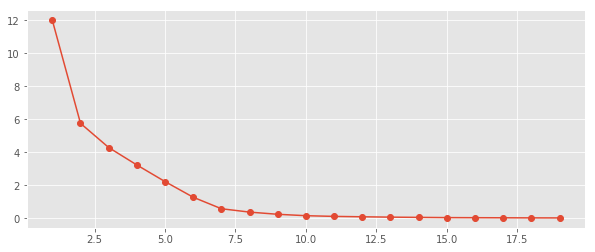






*************************************************************************
*********************** PCA components =  6 *****************************
Variance explained = 41.79%
Inertia =  [12.9260372843375, 6.675847179282342, 5.174734407524738, 4.214953321867991, 3.117621947412886, 2.140482655790324, 1.2621808781102462, 0.7693759387455813, 0.5624407794929689, 0.3829096195525514, 0.2509057312102172, 0.13702283416332067, 0.10945903576378144, 0.0913029497725793, 0.07703433207909183, 0.06336343679320147, 0.05462123307977055, 0.047485646924324665, 0.04316163571756235]


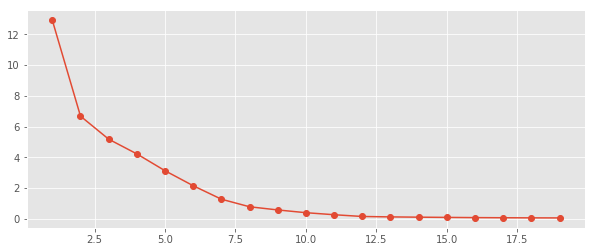






*************************************************************************
*********************** PCA components =  7 *****************************
Variance explained = 44.72%
Inertia =  [13.832599090415581, 7.582165155936275, 6.0915484759982785, 5.040331433321304, 4.016032752299386, 3.0241729261202797, 2.173174183301815, 1.3284634095529002, 0.749606664091417, 0.5071610159247966, 0.3214046353300505, 0.1882150125089142, 0.13785607701803967, 0.11414788318836049, 0.09722717185197552, 0.08182356019261396, 0.0710941239664658, 0.06268693076841225, 0.05308508767772788]


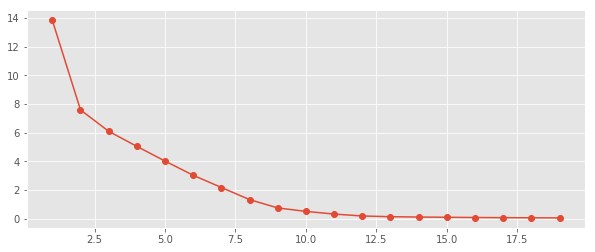






*************************************************************************
*********************** PCA components =  9 *****************************
Variance explained = 49.96%
Inertia =  [15.454241280546984, 9.161947863310502, 8.041029573735084, 6.482363099590063, 5.424563459800279, 4.557905178888331, 3.385905855013748, 2.6080953724316798, 1.7712660795309523, 1.2071632647128125, 0.7054003226690135, 0.4490249678588, 0.2593446385622013, 0.209578044673974, 0.17541217410307158, 0.1511997419111575, 0.12770837581646413, 0.10804171865815175, 0.08833165823839853]


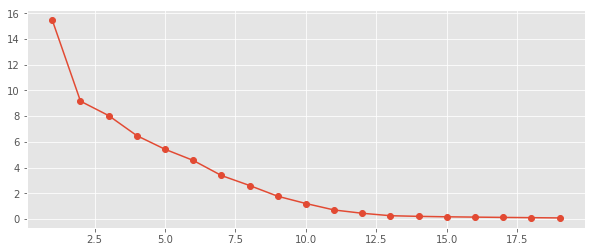






*************************************************************************
*********************** PCA components =  10 *****************************
Variance explained = 52.33%
Inertia =  [16.184866380669384, 9.892537113108155, 8.098251013103363, 6.982687909743767, 5.973353604845243, 5.051507859078322, 4.088517393126226, 3.2791806264861707, 2.3881328656204888, 1.758799573794211, 1.0364539124844336, 0.6087226259031647, 0.41657633344374434, 0.29270186331091225, 0.24214704515629676, 0.19476018509132584, 0.16102535159428155, 0.13940795396615124, 0.11309326786460842]


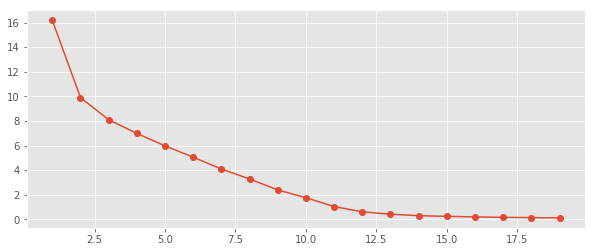






*************************************************************************
*********************** PCA components =  11 *****************************
Variance explained = 54.64%
Inertia =  [16.900025204348758, 10.60484385899504, 8.802623012391445, 7.686679441820829, 6.7974234337014305, 5.787654943881897, 4.933259162147493, 3.979345031491803, 3.0690548991355007, 2.406894438668192, 1.7342417488053945, 1.0909648783025425, 0.6517163225015703, 0.4593837961167749, 0.3260640077823699, 0.2341254431443082, 0.20163273864767908, 0.17030555617421403, 0.144027505993621]


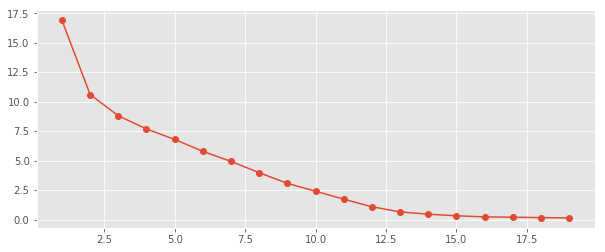






*************************************************************************
*********************** PCA components =  15 *****************************
Variance explained = 63.11%
Inertia =  [19.51902418101962, 13.204393861885372, 11.306191593930524, 10.40752478634565, 9.503431802607224, 8.599526946650352, 7.811456372070257, 6.918431538927983, 6.124149488708301, 5.369429828525511, 4.440931905407424, 3.6855258922285796, 3.2821866288280326, 2.5237637375266484, 1.7447244463224045, 1.069831350892841, 0.8004535983876162, 0.6068391739128352, 0.4372617267639636]


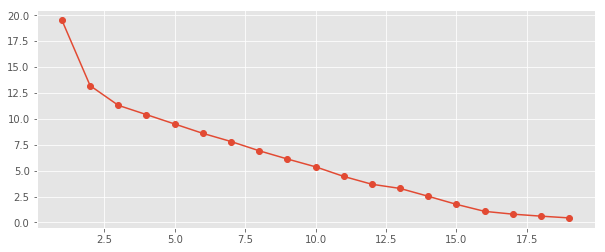






*************************************************************************
*********************** PCA components =  30 *****************************
Variance explained = 85.68%
Inertia =  [26.50150489772071, 20.185145316367887, 18.546603794467796, 17.519257404254596, 16.513886023020973, 15.380071385663424, 14.655157425556887, 13.961720297872144, 13.31938874784942, 12.566990610174532, 11.952109326031678, 11.109135920879712, 9.901780304112341, 9.540364782913784, 8.646565560248867, 7.734878799659182, 7.285490735140634, 6.536051447759106, 5.974329367494914]


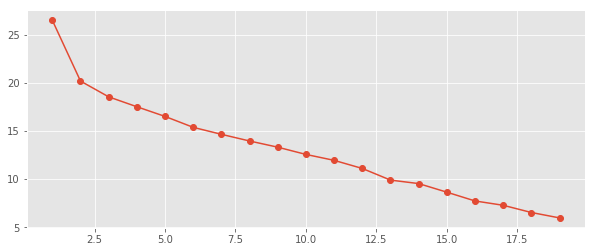






Variance explained = 52.33%


*************** Cluster_no =  1  ******* color =  blue    *****************
['1. grapefruit', '2. cherries', '3. apples', '4. berries', '5. bananas']


*************** Cluster_no =  2  ******* color =  green    *****************
['1. laundry detergent', '2. frozen vegetables', '3. spaghetti sauce', '4. dishwashing', '5. canned vegetables', '6. ice cream', '7. ketchup']


*************** Cluster_no =  3  ******* color =  red    *****************
['1. baby items', '2. waffles', '3. cereals', '4. flour', '5. pasta']


*************** Cluster_no =  4  ******* color =  cyan    *****************
['1. sandwich bags', '2. aluminum foil', '3. paper towels', '4. toilet paper']


*************** Cluster_no =  5  ******* color =  magenta    *****************
['1. shampoo', '2. shaving cream', '3. hand soap', '4. soap']


*************** Cluster_no =  6  ******* color =  yellow    *****************
['1. butter', '2. eggs', '3. milk', '4. cheeses', '5. yogurt']


*

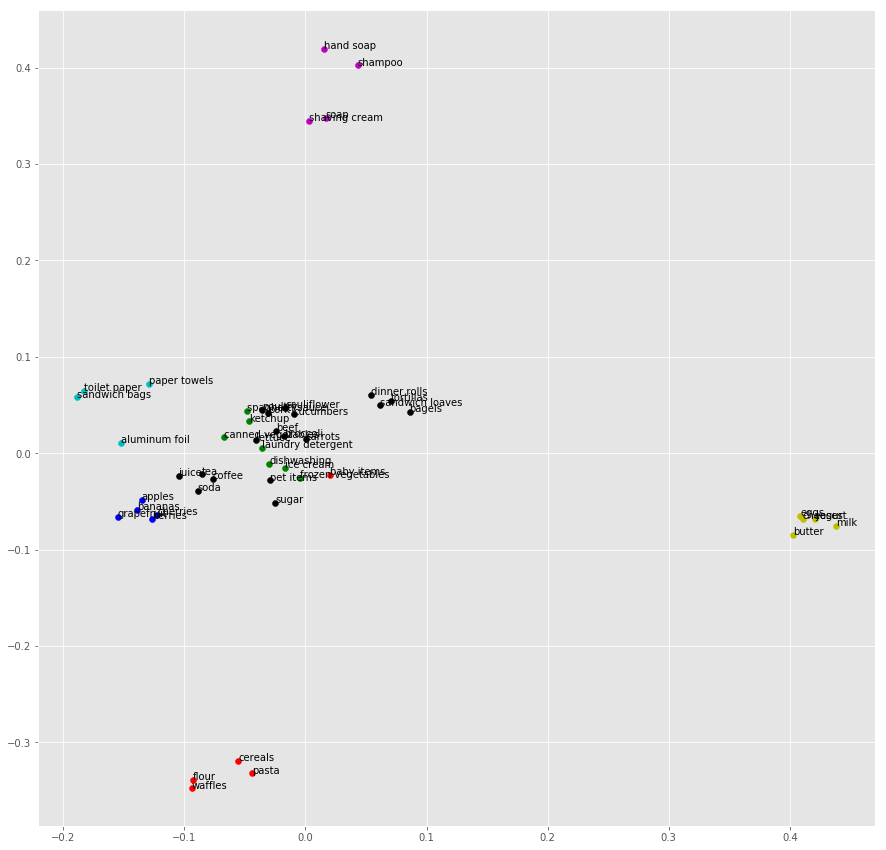

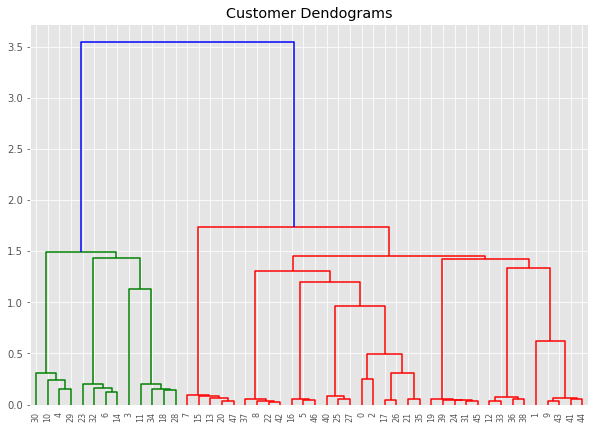

<Figure size 1080x1080 with 0 Axes>

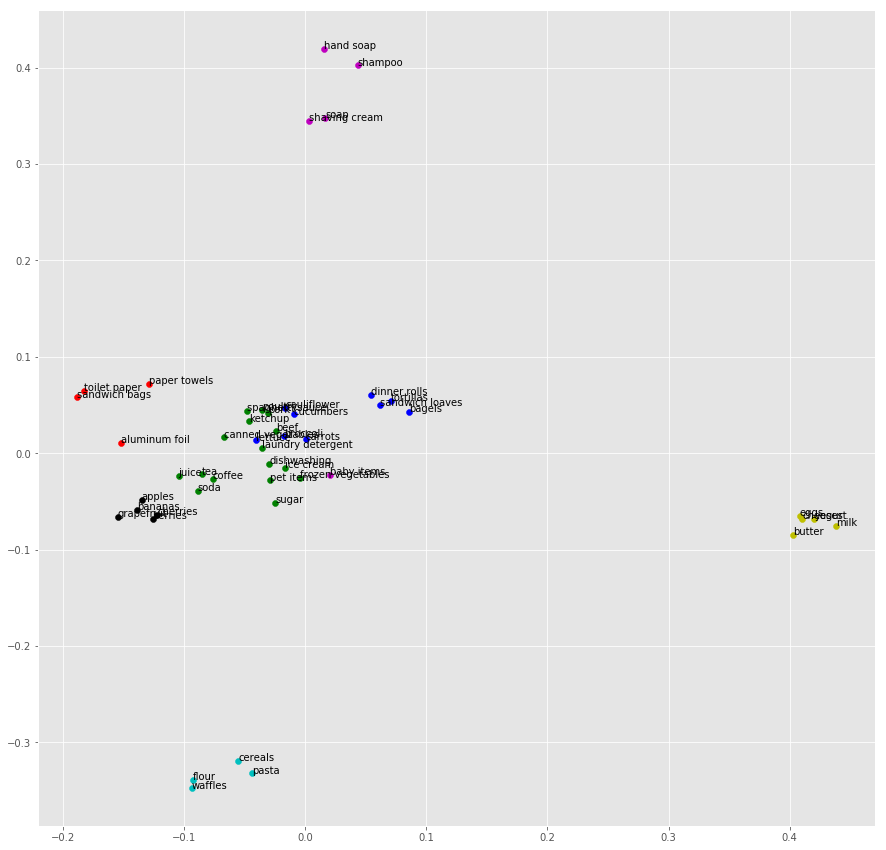

In [10]:
k_means_execution()
hierarchical_execution()